In [182]:
import os
import torch
import gym
import numpy as np
from gym import wrappers
import random
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import copy

In [183]:
env = gym.make('BipedalWalker-v3')

In [184]:
#Hyperparameters

lr = 0.01
directions_amount_N = 16
best_directions_amount_b = 16
max_episode_length = 500
episodes_amount = 700
noise_v = 0.03

In [217]:
class M:
    def __init__(self, in_size, out_size):
        
        self.matrix = torch.zeros((out_size, in_size)).float()

        
    def mult(self, input,delta=0., sign = 0.):
        if sign == 0:
            
            
            return torch.mm(self.matrix.float(), torch.tensor(input).unsqueeze(dim = 1).float())
            
        elif sign > 0:

            return torch.mm(self.matrix.float()+noise_v*delta.float(), torch.tensor(input).unsqueeze(dim=1).float())
            
        else:
            
            return torch.mm(self.matrix.float()-noise_v*delta.float(), torch.tensor(input).unsqueeze(dim = 1).float())
    
    
    def create_delta(self):
        
        return [torch.tensor(np.random.randn(*self.matrix.shape)) for _ in range(directions_amount_N)]
     
    def step(self, rollouts, sigma_r):
        step = torch.zeros(self.matrix.shape)
        for positive, negative, delta in rollouts:
            step += (positive - negative) * delta
        self.matrix += lr / best_directions_amount_b / sigma_r * step

In [218]:
class Norm:
    
    def __init__(self, inputs):
        self.n = torch.zeros(inputs)
        self.mean = torch.zeros(inputs)
        self.mean_diff = torch.zeros(inputs)
        self.var = torch.zeros(inputs)
        
    def observe(self, state):
        self.n += 1.
        last_mean = copy.deepcopy(self.mean)
        self.mean += (state - self.mean) / self.n
        self.mean_diff += (state - last_mean) * (state - self.mean)
        self.var = torch.tensor(np.array(self.mean_diff / self.n).clip(min = 1e-2))
    
    def normalize(self, inputs):
        obs_mean = self.mean
        obs_std = np.sqrt(self.var)
        return (inputs - obs_mean) / obs_std

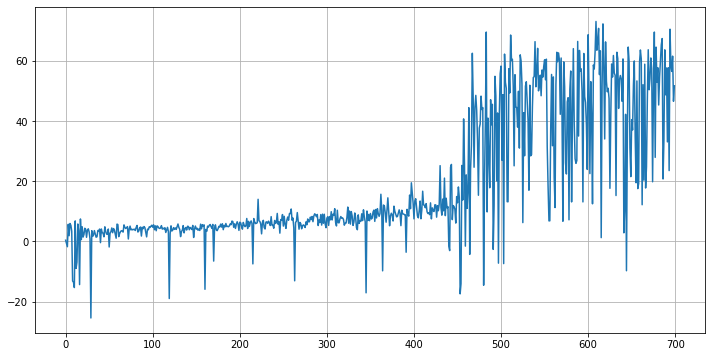

In [221]:
policy = M(env.observation_space.shape[0],env.action_space.shape[0])
final_rewards = []
normalizer = Norm(env.observation_space.shape[0])
for i in range(episodes_amount):
    deltas = policy.create_delta()
    
    pos_rewards = torch.zeros(directions_amount_N)
    neg_rewards = torch.zeros(directions_amount_N)
    
    for j in range(directions_amount_N):
        state = env.reset()
        done = False
        traj_amount = 0
        reward_sum = 0
        while not done and traj_amount < max_episode_length:
            normalizer.observe(torch.tensor(state))
            state = normalizer.normalize(torch.tensor(state))
            action = policy.mult(state, deltas[j], 1.)
            state, reward, done, _ = env.step(action)
            reward = max(min(reward, 1), -1)
            reward_sum += reward
            traj_amount += 1
        
        pos_rewards[j] = reward_sum
        
        state = env.reset()
        done = False
        traj_amount = 0
        reward_sum = 0
        while not done and traj_amount < max_episode_length:
            normalizer.observe(torch.tensor(state))
            state = normalizer.normalize(torch.tensor(state))
            action = policy.mult(state, deltas[j], -1.)
            state, reward, done, _ = env.step(action)
            reward = max(min(reward, 1), -1)
            reward_sum += reward
            traj_amount += 1
        
        neg_rewards[j] = reward_sum  
    
    rewards_sum = torch.cat((pos_rewards,neg_rewards))
    sigma_r = rewards_sum.std()
    
    scores = {k:max(r_pos, r_neg) for k,(r_pos,r_neg) in enumerate(zip(pos_rewards, neg_rewards))}
    order = sorted(scores.keys(), key = lambda x:scores[x], reverse = True)[:best_directions_amount_b]
    rollouts = [(pos_rewards[k], neg_rewards[k], deltas[k]) for k in order]
    
    policy.step(rollouts, sigma_r)
    
    state= env.reset()
    done = False
    traj_amount = 0
    reward_sum = 0
    while not done and traj_amount < max_episode_length:
        normalizer.observe(torch.tensor(state))
        state = normalizer.normalize(torch.tensor(state))
        action = policy.mult(state, deltas[j], 1)
        state, reward, done, _ = env.step(action)
        reward = max(min(reward, 1), -1)
        reward_sum += reward
        traj_amount += 1

    final_rewards.append(reward_sum)
    clear_output(True)
    plt.figure(figsize=[12, 6])
    plt.grid()
    plt.plot(list(range(len(final_rewards))), final_rewards)
    plt.show()
    